In [382]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set display options to show all columns
pd.set_option('display.max_columns', None)
np.random.seed(42)  # You can use any integer value as the seed

CWD = os.getcwd()
print(f'CWD: {CWD}')

CWD: /data_analysis/IT_support/src


In [383]:
cardinal_cols = ['number', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'contact_type', 'location', 'u_symptom']
ordinal_cols = ['incident_state', 'reassignment_count', 'reopen_count', 'sys_mod_count', 'impact', 'urgency', 'priority']

boolean_cols = ['cmdb_ci', 'u_priority_confirmation',]

dt_cols = ['opened_at', 'sys_created_at', 'sys_updated_at']

# to_remove = ['made_sla', 'knowledge', 'notify', 'problem_id', 'rfc', 'vendor', 'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
#              'assignment_group', 'assigned_to', 'category', 'subcategory', 'active']

all_cols = cardinal_cols + ordinal_cols + boolean_cols + dt_cols
len(all_cols)

20

In [384]:
ROOT = os.path.dirname(CWD)
PATH = os.path.join(ROOT, 'data', 'incident_event_cleaned.csv')

df = pd.read_csv(PATH, low_memory=False, index_col=0)
# Convert the date columns in proper format so we can do calculations on them
for col in dt_cols:
    df[col] = pd.to_datetime(df[col])
df.sample(5)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,update_to_closing_days
32731,INC0007320,Resolved,True,0.0,0.0,1.0,True,Caller 1177,Opened by 386,2016-03-15 13:54:00,NaN,NaT,Updated by 723,2016-03-15 14:07:00,Phone,Location 55,Category 46,Subcategory 223,NaN,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 186,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 169,15/3/2016 14:07,9.204167
91383,INC0022001,Active,True,0.0,0.0,1.0,True,Caller 3912,Opened by 463,2016-04-25 00:40:00,NaN,NaT,Updated by 846,2016-04-25 01:13:00,Phone,Location 161,Category 26,Subcategory 174,Symptom 491,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 218,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 199,25/4/2016 01:37,5.037500
110358,INC0026712,Resolved,True,0.0,0.0,1.0,True,Caller 2535,Opened by 24,2016-05-06 09:21:00,NaN,NaT,Updated by 60,2016-05-06 09:35:00,Phone,Location 44,Category 42,Subcategory 223,Symptom 534,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 17,False,True,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 15,6/5/2016 09:35,5.022222
58225,INC0013455,Awaiting User Info,True,2.0,0.0,10.0,True,Caller 4976,NaN,2016-03-31 10:57:00,NaN,NaT,Updated by 421,2016-04-11 08:31:00,Phone,Location 108,Category 40,Subcategory 215,NaN,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,NaN,False,False,Do Not Notify,NaN,NaN,NaN,NaN,code 7,Resolved by 15,12/4/2016 16:12,6.358333
36119,INC0008036,Awaiting User Info,True,0.0,0.0,8.0,True,Caller 1010,Opened by 443,2016-03-17 05:41:00,NaN,NaT,Updated by 664,2016-03-18 16:36:00,Phone,Location 204,Category 57,Subcategory 170,NaN,NaN,1 - High,1 - High,1 - Critical,Group 65,Resolver 180,False,False,Do Not Notify,NaN,NaN,NaN,NaN,NaN,Resolved by 163,23/3/2016 14:42,9.932639


## Feature Engineering
Create new features using Sklearn `FunctionTransformer` this way everything can be put together in the pipeline.

In [385]:
from sklearn.base import BaseEstimator, TransformerMixin


In [386]:
# Models cannot handle datetime format by itself. Split datetime components to separate components.
class SplitDateTimeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        cols = X_transformed.select_dtypes(include=['datetime64']).columns.to_list()
        for col in cols:
            for component in ['year', 'month', 'day', 'hour', 'minute', 'second']:
                new_col_name = f'{col}_{component}'
                X_transformed[new_col_name] = X_transformed[col].dt.__getattribute__(component).astype(float)
        X_transformed.drop(columns=cols, inplace=True)

        return X_transformed

# Drop the original datetime columns and the columns used for computations
class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()
        cols = X_transformed.select_dtypes(include=['datetime64']).columns.to_list()
        if self.columns_to_drop is not None:
            cols += self.columns_to_drop
        X_transformed.drop(columns=cols, inplace=True)

        return X_transformed

In [387]:
# Custom transformer for target encoding
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        cols = X.columns.to_list()
        temp_df = pd.concat([X, y], axis=1)
        category_means_ = []
        for col in cols:
            category_means_.append(temp_df.groupby(col)[y.name].mean().to_dict())
        self.category_means_ = category_means_
        return self

    def transform(self, X):
        X_encoded = X.copy()
        cols = X_encoded.columns.to_list()
        for i, col in enumerate(cols):
            X_encoded[col] = X[col].map(self.category_means_[i])
        return X_encoded

### Pipeline

In [388]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import SelectPercentile, chi2, SelectKBest, SelectFromModel, VarianceThreshold
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
# from lightgbm import LGBMRegressor


from sklearn.metrics import mean_squared_error

In [389]:
# Create the column transformer

cardinal_cols = ['contact_type', 'location', 'u_symptom']
ordinal_cols = ['incident_state', 'sys_mod_count', 'priority',]
boolean_cols = ['cmdb_ci', 'u_priority_confirmation',]
dt_cols = ['opened_at', 'sys_created_at', 'sys_updated_at', 'number', 'incident_state', 'priority'] # Number & incident_state are here for feature engineering. will be dropped later.

categorical_features = cardinal_cols + ordinal_cols + boolean_cols
datetime_features = dt_cols

categorical_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder()),
    # ('scaling', StandardScaler()),
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

datetime_transformer = Pipeline(steps=[
    ('split_dt_parts', SplitDateTimeTransformer()),
    ('drop_cols', DropColumnsTransformer(columns_to_drop=['number', 'incident_state', 'priority'])),
    ('encoder', TargetEncoder()),
    # ('scaling', StandardScaler()),
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('datetime', datetime_transformer, datetime_features),
    ], remainder='drop'
)

# Create the final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('feature_selector', VarianceThreshold(0.01)),
                        #    ('model', TransformedTargetRegressor(regressor=XGBRegressor(),
                        #                   transformer=PowerTransformer()))
                            ('model', XGBRegressor())
                           ])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder()),
                                                                  ('imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'))]),
                                                  ['contact_type', 'location',
                                                   'u_symptom',
                                                   'incident_state',
                                                   'sys_mod_count', 'priority',
                                                   'cmdb_ci',
                                                   'u_priority_confirmation']),
                                                 ('datetime',
                                                  Pipeline(steps=[('split_dt_pa...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

### Train Test Split

In [390]:
# Define the features and target
df.sort_values(['opened_at', 'number'])

# Define the groups based on the 'number' column
groups = df['number']

# Get unique group values
unique_groups = groups.unique()
split_idx = int(0.8 * len(unique_groups))

# train_num, test_num = train_test_split(unique_groups, test_size = 0.2, random_state=42)
train_num, test_num = unique_groups[:split_idx], unique_groups[split_idx:]
train = df[df['number'].isin(train_num)]
test = df[df['number'].isin(test_num)]

X_train, y_train = train.drop(columns=['update_to_closing_days',]), train['update_to_closing_days']
X_test, y_test = test.drop(columns=['update_to_closing_days',]), test['update_to_closing_days']

### Naive Predictions

In [391]:
# Compute the mean and standard deviation of y_train
mean_y_train = np.mean(y_train)
std_dev_y_train = np.std(y_train)

# Generate y_preds using random normal distribution
y_pred = np.random.normal(loc=mean_y_train, scale=std_dev_y_train, size=len(y_test))

# Calculate the mean squared error (MSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (MSE): {rmse}")

Root Mean Squared Error (MSE): 6.85105090751942


### Model Prediction

In [392]:
# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Calculate the mean squared error (MSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (MSE): {rmse}")

Root Mean Squared Error (MSE): 3.81427362605479


### Fine tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GroupKFold

# Define the number of folds for cross-validation
n_splits = 5  # You can adjust this as needed

# Create a GroupKFold cross-validator using the 'number' column as groups
group_kfold = GroupKFold(n_splits=n_splits)

# Define the hyperparameter grid for XGBoostRegressor
param_dist_xgb = {
    'model': [XGBRegressor()],
    'model__regressor__n_estimators': np.linspace(100, 500, 5, dtype=int),
    'model__regressor__learning_rate': np.logspace(-3, 0, 20),
    'model__regressor__max_depth': np.linspace(3, 10, 8, dtype=int),
    'model__regressor__min_child_weight': np.linspace(1, 5, 5, dtype=int),
    'model__regressor__subsample': np.linspace(0.8, 1.0, 3),
    'model__regressor__colsample_bytree': np.linspace(0.8, 1.0, 3),
    'model__regressor__gamma': np.linspace(0, 5, 50)
}

# param_grid_lgbm = {
#     'model': [LGBMRegressor()],
#     'model__learning_rate': np.logspace(-3, 0, 20),
#     # 'model__max_depth': np.linspace(3, 10, 8, dtype=int),
#     # 'model__min_child_weight': np.linspace(1, 5, 5, dtype=int),
#     # 'model__subsample': np.linspace(0.8, 1.0, 3),
#     # 'model__colsample_bytree': np.linspace(0.8, 1.0, 3),
#     # 'model__num_leaves': np.linspace(10, 50, 5, dtype=int)
# }

param_grid_catboost = {
    'model': [CatBoostRegressor(logging_level='Silent')],
    'model__learning_rate': np.logspace(-3, 0, 20),
    # 'model__depth': np.linspace(3, 10, 8, dtype=int),
    # 'model__min_child_samples': np.linspace(1, 5, 5, dtype=int),
    # 'model__subsample': np.linspace(0.8, 1.0, 3),
    # 'model__colsample_bylevel': np.linspace(0.8, 1.0, 3),
    # 'model__iterations': np.linspace(100, 500, 5, dtype=int)
}


param_dist_rf = {
    'model': [RandomForestRegressor()],
    'model__n_estimators': np.linspace(50, 200, 4, dtype=int),
    'model__max_depth': [None] + list(np.linspace(10, 30, 4, dtype=int)),
    'model__min_samples_split': np.linspace(2, 10, 5, dtype=int),
    'model__min_samples_leaf': np.linspace(1, 4, 4, dtype=int)
}


all_params = [param_dist_xgb,
            #   param_dist_rf,
            #   param_grid_lgbm,
            #   param_grid_catboost
              ]

all_params = [{**params, 'feature_selector__threshold': np.logspace(-3,0,5)} for params in all_params]



# Create the RandomizedSearchCV object with GroupKFold
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=all_params,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=group_kfold,  # Use GroupKFold for cross-validation
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

# Fit the RandomizedSearchCV object on your data
random_search.fit(X_train, y_train, groups=X_train['number'])  # Pass the 'number' column as groups

# Get the best hyperparameters and estimator from the search
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

# Print the best hyperparameters
print(f'Best Hyperparameters: {best_params}')

# Make predictions on the test data
y_pred = ss.inverse_transform(best_estimator.predict(X_test))

# Calculate the mean squared error (MSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (MSE): {rmse}")

### Error Analysis

In [353]:
Xdf = X_train.copy()
Xdf['y_train'] = y_train
Xdf['y_preds'] = best_estimator.predict(X_train)
Xdf['y_res'] = Xdf['y_train'] - Xdf['y_preds']

<Axes: xlabel='y_train', ylabel='Density'>

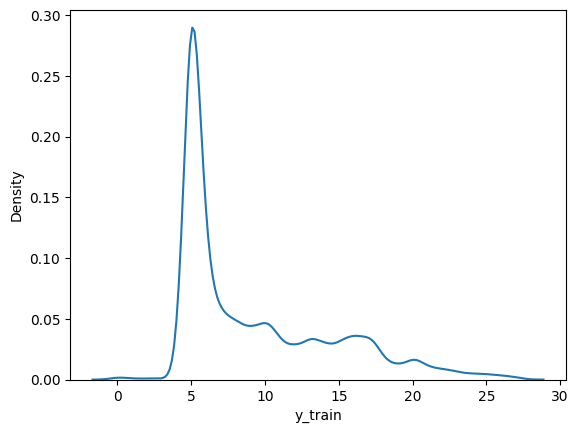

In [395]:
from sklearn.preprocessing import PowerTransformer
# Xdf['y_train_log'] = np.log(Xdf['y_train'])
# Xdf['y_train_sqrt'] = np.sqrt(Xdf['y_train'])
pt = PowerTransformer()
Xdf['y_train_pt'] = pt.fit_transform(Xdf[['y_train']])

sns.kdeplot(data=Xdf, x='y_train')

In [347]:
Xdf['incident_state'].unique()

array(['New', 'Resolved', 'Active', 'Awaiting User Info',
       'Awaiting Problem', 'Awaiting Vendor'], dtype=object)

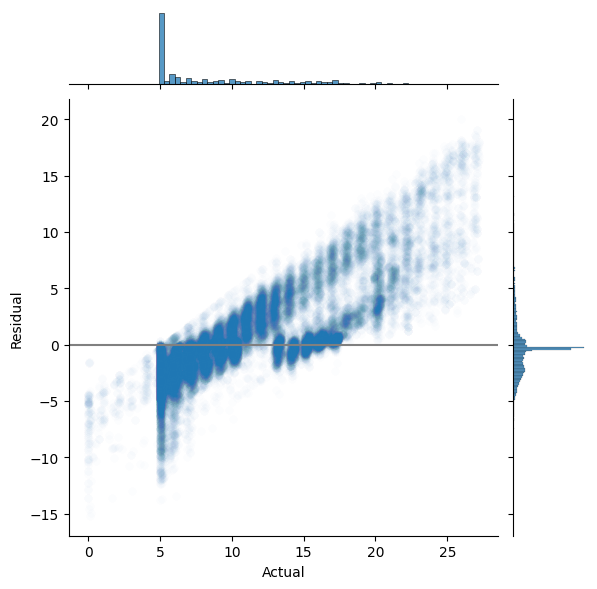

In [368]:
to_plot = 'incident_state'
to_plot_cat = 'New'
sns.jointplot(data=Xdf, x='y_train', y='y_res', alpha=0.01)
plt.xlabel('Actual')
plt.ylabel('Residual')
plt.axhline(y=0, color='gray')
plt.show()

In [275]:
Xdf['incident_state'].value_counts()

incident_state
Active                24827
New                   22155
Resolved              15890
Awaiting User Info     9354
Awaiting Problem        246
Awaiting Vendor          13
Name: count, dtype: int64

In [276]:
# Define a custom function to compute RMSE for a group
def compute_rmse(group):
    return np.sqrt(mean_squared_error(group['y_train'], group['y_preds']))

# Use groupby and apply to compute RMSE by category
rmse_by_category = Xdf.groupby('incident_state').apply(compute_rmse).reset_index()
rmse_by_category.columns = ['incident_state', 'RMSE']

# Print or work with the RMSE values by category
print(rmse_by_category)

       incident_state      RMSE
0              Active  3.617217
1    Awaiting Problem  4.173372
2  Awaiting User Info  3.377806
3     Awaiting Vendor  5.115939
4                 New  4.296977
5            Resolved  0.908957


In [277]:
# Use groupby and apply to compute RMSE by category
rmse_by_category = Xdf.groupby('priority').apply(compute_rmse).reset_index()
rmse_by_category.columns = ['priority', 'RMSE']

# Print or work with the RMSE values by category
print(rmse_by_category)

       priority      RMSE
0  1 - Critical  3.656886
1      2 - High  3.819112
2  3 - Moderate  3.417317
3       4 - Low  3.768434


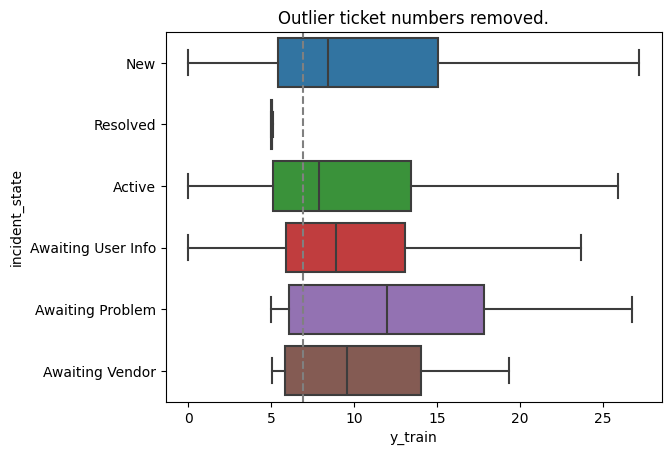

In [278]:
dd_median = Xdf['y_train'].median()
sns.boxplot(Xdf, x='y_train', y='incident_state', showfliers=False)
plt.axvline(x=dd_median, color='gray', linestyle='--', label='Median')
plt.title('Outlier ticket numbers removed.')
plt.show()